In [1]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from coffea import hist, processor 
from coffea.hist import plot
from coffea.util import load, save

In [2]:
hists = load('../hists/darkhiggs2017.scaled')

In [3]:
data_hists   = hists['data']
bkg_hists    = hists['bkg']
signal_hists = hists['sig']

In [4]:
data_hists['recoil'].identifiers('process')

[<StringBin (MET) instance at 0x7f919deb94a8>,
 <StringBin (SingleElectron) instance at 0x7f919deb94e0>,
 <StringBin (SinglePhoton) instance at 0x7f919deb9518>]

In [5]:
exp = 0
region = 'sr'
sys = 'nominal'
data={}
data['sr'] = 'MET'
data['wmcr'] = 'MET'
data['tmcr'] = 'MET'
data['wecr'] = 'SingleElectron'
data['tecr'] = 'SingleElectron'
data['zmcr'] = 'MET'
data['zecr'] = 'SingleElectron'
data['gcr'] = 'SinglePhoton'

variable = 'recoil'
cut_bin = 0
nbins = data_hists[variable].integrate('systematic',sys).integrate('region').integrate('process', 'MET').sum('gentype').values(overflow='all')[()].size
cut_value_array = data_hists[variable].integrate('systematic',sys).integrate('region').integrate('process', 'MET').axis(variable).edges(overflow='all')

print('------------------------')
print('------------------------')
print('Category:', region)
print('Systematic:', sys)
#print('------------------------')
if cut_bin!=0: print(variable,'> %.2f' % cut_value_array[()][cut_bin])
print('------------------------')
print('------------------------')
for p in bkg_hists[variable].identifiers('process'):
    yld_array = bkg_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process', p).sum('gentype').values(overflow='all')
    if () in yld_array:
        yld = np.cumsum(yld_array[()])[nbins-1] - np.cumsum(yld_array[()])[cut_bin]
        exp += yld
        print(p, '%.1f' % yld)

print('------------------------')
print('Total expected:', '%.1f' % exp)
print('------------------------')

for p in signal_hists[variable].identifiers('process'):
    yld_array = signal_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process', p).sum('gentype').values(overflow='all')
    if () in yld_array:
        yld = np.cumsum(yld_array[()])[nbins-1] - np.cumsum(yld_array[()])[cut_bin]
        print(p, '%.1f' % yld)
        print(p,'S/B %.3f' % (yld/exp))
        print(p,'S/sqrt(B) %.1f' % (yld/np.sqrt(exp)))
        #print(p,'Fraction %.2f' % (yld/np.cumsum(yld_array[()])[16]))
        print('------------------------')

if not region == 'sr':
    yld_array = data_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process', data[region.split('_')[0]]).sum('gentype').values(overflow='all')
    if () in yld_array:
        yld = np.cumsum(yld_array[()])[nbins-1] - np.cumsum(yld_array[()])[cut_bin]
        print('Total observed:', '%.1f' % yld)   
print('------------------------')
print()

------------------------
------------------------
Category: sr
Systematic: nominal
------------------------
------------------------
Hbb 98.5
DY+HF 66.5
DY+LF 1034.0
WW 1538.4
WZ 2496.9
ZZ 1636.6
ST 1435.7
TT 5481.2
W+HF 11969.1
W+LF 85845.8
Z+HF 15566.7
Z+LF 165344.2
QCD 2985.8
------------------------
Total expected: 295499.4
------------------------
------------------------



In [4]:
gentype_map = {
    'garbage':  0,
    'xbb':      1,
    'tbcq':     2,
    'tbqq':     3,
    'zcc':      4,
    'wcq':      5,
    'vqq':      6,
    'bb':       7,
    'bc':       8,
    'b':        9,
    'cc' :     10,
    'c':       11,
    'other':   12
}

In [5]:
exp = 0
region = 'sr'
sys = 'nominal'
data={}
data['sr'] = 'MET'
data['wmcr'] = 'MET'
data['tmcr'] = 'MET'
data['wecr'] = 'SingleElectron'
data['tecr'] = 'SingleElectron'
data['zmcr'] = 'MET'
data['zecr'] = 'SingleElectron'
data['gcr'] = 'SinglePhoton'

variable = 'ZHbbvsQCD'
cut_bin = 8
nbins = data_hists[variable].integrate('systematic',sys).integrate('region').integrate('process', 'MET').sum('gentype').values()[()].size
cut_value_array = data_hists[variable].integrate('systematic',sys).integrate('region').integrate('process', 'MET').axis(variable).edges()

print('------------------------')
print('------------------------')
print('Category:', region)
print('Systematic:', sys)
#print('------------------------')
if cut_bin!=0: print(variable,'> %.2f' % cut_value_array[()][cut_bin])
print('------------------------')
print('------------------------')
for g in gentype_map.keys():
    yld_array = bkg_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process').values()[()][gentype_map[g]]
    yld = np.cumsum(yld_array[()])[nbins-1] - np.cumsum(yld_array[()])[cut_bin]
    tot = bkg_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process').sum(variable).values()[()][gentype_map[g]]
    eff = np.nan_to_num(yld/tot)
    print(g, '%.3f' % eff)
print('------------------------')
print()

------------------------
------------------------
Category: sr
Systematic: nominal
ZHbbvsQCD > 0.53
------------------------
------------------------
garbage 0.546
xbb 0.917
tbcq 0.714
tbqq 0.528
zcc 0.364
wcq 0.236
vqq 0.070
bb 0.776
bc 0.645
b 0.578
cc 0.291
c 0.173
other 0.065
------------------------



In [11]:
#Calculating pass/fail efficiencies 
deepak15_pass_eff={}
num={}
den={}
for g in gentype_map.keys():
    #if () not in bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','sr').integrate('process').values(): continue
    vnum = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','sr_monohs').integrate('process').sum('recoil').values()[()][gentype_map[g]]
    vden = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','sr').integrate('process').sum('recoil').values()[()][gentype_map[g]]
    deepak15_pass_eff[str(g)]=vnum/vden

In [12]:
deepak15_pass_eff

{'garbage': 0.08406968511305318,
 'xbb': 0.8815403227255647,
 'tbcq': 0.6816232685978727,
 'tbqq': 0.5528229644385104,
 'zcc': 0.3982168800577921,
 'wcq': 0.21243505834534634,
 'vqq': 0.05292137658510044,
 'bb': 0.7858699870979197,
 'bc': 0.7275190352225822,
 'b': 0.5865275253718004,
 'cc': 0.25197261181990355,
 'c': 0.1589768626996781,
 'other': 0.05539193506726003}

In [10]:
file='../data/deepak15_pass_eff.json'
with open(file, "w") as fout:
    json.dump(deepak15_pass_eff, fout, indent=4)

In [13]:
#Measuring W+jets HF fraction
WHF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'W+HF').values()[()].sum()
WHF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'W+HF').values()[()].sum()
WHF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'W+HF').values()[()].sum()
WHF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'W+HF').values()[()].sum()
WLF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'W+LF').values()[()].sum()
WLF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'W+LF').values()[()].sum()
WLF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'W+LF').values()[()].sum()
WLF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'W+LF').values()[()].sum()

WHF_tot = WHF_wmcr+WHF_wecr+WHF_tmcr+WHF_tecr
WLF_tot = WLF_wmcr+WLF_wecr+WLF_tmcr+WLF_tecr

whf_fraction = WHF_tot/(WHF_tot+WLF_tot)

In [36]:
whf_fraction

0.17746649595085495

In [37]:
#Measuring Z+jets HF fraction
ZHF_zmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','zmcr').integrate('process', 'DY+HF').values()[()].sum()
ZHF_zecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','zecr').integrate('process', 'DY+HF').values()[()].sum()
ZLF_zmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','zmcr').integrate('process', 'DY+LF').values()[()].sum()
ZLF_zecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','zecr').integrate('process', 'DY+LF').values()[()].sum()

ZHF_tot = ZHF_zmcr+ZHF_zecr
ZLF_tot = ZLF_zmcr+ZLF_zecr

zhf_fraction = ZHF_tot/(ZHF_tot+ZLF_tot)

In [38]:
zhf_fraction

0.10100548625886022

In [39]:
#Measuring gamma+jets HF fraction
GHF_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr').integrate('process', 'G+HF').values()[()].sum()
GLF_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr').integrate('process', 'G+LF').values()[()].sum()

ghf_fraction = GHF_gcr/(GHF_gcr+GLF_gcr)

In [40]:
ghf_fraction

0.12130748847455622

In [14]:
#Measuring ak4 0-tag efficiency per process per gentype
#Interested just in the overall rate effect, to estimate how the application of the ak4 b-tagging requirement 
#changes the relative fraction of the single components per process.
#Effect hasd been checked, and the efficiency does not depend on the recoil values (modulo stat fluctuations)

deepak4_0tag_eff = {}
for p in bkg_hists['recoil'].integrate('region','wmcr').identifiers('process'):
    deepak4_0tag_eff[str(p)]={}
    for g in gentype_map.keys():
        wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        eff = np.nan_to_num((wmcr+wecr)/(wmcr+wecr+tmcr+tecr))
        if eff != 0.0: 
            deepak4_0tag_eff[str(p)][str(g)] = eff.tolist()
            print(str(p),str(g),deepak4_0tag_eff[str(p)][str(g)])

Hbb garbage 0.6681515195044839
Hbb xbb 0.8702797457327418
Hbb tbcq 0.28857387435456583
Hbb tbqq 0.3073587988862988
Hbb wcq 0.22276137820719588
Hbb vqq 0.23169048391306707
Hbb bb 0.46577579929218926
Hbb bc 0.3840483532960525
Hbb b 0.6831701863064119
Hbb other 0.44517649589908925
DY+HF garbage 0.7669458093155593
DY+HF bb 0.8936591378572178
DY+HF b 0.8000248018081935
DY+HF cc 0.8969643259344457
DY+HF c 0.8621271737227711
DY+HF other 0.6539400995378546
DY+LF garbage 0.887635065011856
DY+LF other 0.8961670910683162
VV garbage 0.8688395188612178
VV xbb 0.9420784496005731
VV zcc 0.9386080055155718
VV wcq 0.9336704840279402
VV vqq 0.9282157592091711
VV b 0.5679288011979906
VV c 0.890598381016679
VV other 0.84683551203396
ST garbage 0.6085532171065424
ST tbcq 0.805192850771262
ST tbqq 0.8161550416998553
ST wcq 0.5692760838903452
ST vqq 0.5717713633462728
ST bb 0.837585219584388
ST bc 0.7094721566045914
ST b 0.6219506520513284
ST c 0.4458807145251194
ST other 0.43460956267671924
TT garbage 0.417

In [15]:
deepak4_0tag_eff

{'Hbb': {'garbage': 0.6681515195044839,
  'xbb': 0.8702797457327418,
  'tbcq': 0.28857387435456583,
  'tbqq': 0.3073587988862988,
  'wcq': 0.22276137820719588,
  'vqq': 0.23169048391306707,
  'bb': 0.46577579929218926,
  'bc': 0.3840483532960525,
  'b': 0.6831701863064119,
  'other': 0.44517649589908925},
 'DY+HF': {'garbage': 0.7669458093155593,
  'bb': 0.8936591378572178,
  'b': 0.8000248018081935,
  'cc': 0.8969643259344457,
  'c': 0.8621271737227711,
  'other': 0.6539400995378546},
 'DY+LF': {'garbage': 0.887635065011856, 'other': 0.8961670910683162},
 'VV': {'garbage': 0.8688395188612178,
  'xbb': 0.9420784496005731,
  'zcc': 0.9386080055155718,
  'wcq': 0.9336704840279402,
  'vqq': 0.9282157592091711,
  'b': 0.5679288011979906,
  'c': 0.890598381016679,
  'other': 0.84683551203396},
 'ST': {'garbage': 0.6085532171065424,
  'tbcq': 0.805192850771262,
  'tbqq': 0.8161550416998553,
  'wcq': 0.5692760838903452,
  'vqq': 0.5717713633462728,
  'bb': 0.837585219584388,
  'bc': 0.7094721

In [16]:
file='../data/deepak4_0tag_eff.json'
with open(file, "w") as fout:
    json.dump(deepak4_0tag_eff, fout, indent=4)

In [17]:
#Measuring ak4 0-tag efficiency per process, inclusive per gentyope

deepak4_0tag_process_eff = {}
for p in bkg_hists['recoil'].integrate('region','wmcr').identifiers('process'):
    wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).values()[()].sum()
    wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).values()[()].sum()
    tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).values()[()].sum()
    tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).values()[()].sum()
    eff = np.nan_to_num((wmcr+wecr)/(wmcr+wecr+tmcr+tecr))
    if eff != 0.0: 
        deepak4_0tag_process_eff[str(p)] = np.nan_to_num((wmcr+wecr)/(wmcr+wecr+tmcr+tecr))
        print(str(p),deepak4_0tag_process_eff[str(p)])

Hbb 0.740555262764902
DY+HF 0.7841888235484544
DY+LF 0.8919128014751053
VV 0.88984405976984
ST 0.6499343769678404
TT 0.5147407196105054
W+HF 0.8587729399436966
W+LF 0.9030101162281751
QCD 0.8421918397532595


In [18]:
deepak4_0tag_process_eff

{'Hbb': 0.740555262764902,
 'DY+HF': 0.7841888235484544,
 'DY+LF': 0.8919128014751053,
 'VV': 0.88984405976984,
 'ST': 0.6499343769678404,
 'TT': 0.5147407196105054,
 'W+HF': 0.8587729399436966,
 'W+LF': 0.9030101162281751,
 'QCD': 0.8421918397532595}

In [19]:
file='../data/deepak4_0tag_process_eff.json'
with open(file, "w") as fout:
    json.dump(deepak4_0tag_process_eff, fout, indent=4)

In [51]:
#Measuring ak4 0-tag efficiency for inclusive Z+jets
DYHF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'DY+HF').values()[()].sum()
DYHF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'DY+HF').values()[()].sum()
DYHF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'DY+HF').values()[()].sum()
DYHF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'DY+HF').values()[()].sum()
DYLF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'DY+LF').values()[()].sum()
DYLF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'DY+LF').values()[()].sum()
DYLF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'DY+LF').values()[()].sum()
DYLF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'DY+LF').values()[()].sum()

zerotag_tot = DYHF_wmcr+DYHF_wecr+DYLF_wmcr+DYLF_wecr
onetag_tot = DYHF_tmcr+DYHF_tecr+DYLF_tmcr+DYLF_tecr

deepak4_0tag_zj_eff = zerotag_tot/(zerotag_tot+onetag_tot)

In [52]:
deepak4_0tag_zj_eff

0.8819585270181931

In [53]:
#Measuring ak4 0-tag efficiency for inclusive W+jets
WHF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'W+HF').values()[()].sum()
WHF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'W+HF').values()[()].sum()
WHF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'W+HF').values()[()].sum()
WHF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'W+HF').values()[()].sum()
WLF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'W+LF').values()[()].sum()
WLF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'W+LF').values()[()].sum()
WLF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'W+LF').values()[()].sum()
WLF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'W+LF').values()[()].sum()

zerotag_tot = WHF_wmcr+WHF_wecr+WLF_wmcr+WLF_wecr
onetag_tot = WHF_tmcr+WHF_tecr+WLF_tmcr+WLF_tecr

deepak4_0tag_wj_eff = zerotag_tot/(zerotag_tot+onetag_tot)

In [54]:
deepak4_0tag_wj_eff

0.8951594995622084

In [20]:
#measuring signal absolute fractions
abs_signal_fractions = {}
for p in signal_hists['recoil'].identifiers('process'):
    abs_signal_fractions[str(p)]={}
    for g in gentype_map.keys():
        num_sr = signal_hists['recoil'].integrate('systematic','nominal').integrate('region','sr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_sr = signal_hists['recoil'].integrate('systematic','nominal').integrate('region','sr').integrate('process', p).values()[()].sum()
        frac = np.nan_to_num((num_sr)/(den_sr))
        if frac != 0.0:
            abs_signal_fractions[str(p)][str(g)] = frac
            print(str(p),str(g),abs_signal_fractions[str(p)][str(g)])

Mhs_50 garbage 0.003387577181013995
Mhs_50 xbb 0.8045324917887353
Mhs_50 bb 0.00648073165791242
Mhs_50 b 0.08302834124499209
Mhs_50 other 0.10257085812734607
Mhs_70 garbage 0.0018570784291813615
Mhs_70 xbb 0.8350278230947332
Mhs_70 bb 0.012210205201966872
Mhs_70 b 0.08583100876916823
Mhs_70 other 0.06507388450495016
Mhs_90 garbage 0.0013836708447981278
Mhs_90 xbb 0.8314272974817222
Mhs_90 bb 0.01600927474363937
Mhs_90 b 0.10233219338918592
Mhs_90 other 0.048847563540654663
MonoJet garbage 0.0002519128731282428
MonoJet cc 0.0059498113044280905
MonoJet c 0.024397848353558457
MonoJet other 0.9694004274688853
MonoW garbage 0.0010263435371734412
MonoW wcq 0.36476527153660926
MonoW vqq 0.3855819446788135
MonoW c 0.04638437169661257
MonoW other 0.20224206855079133
MonoZ garbage 0.000427093542258451
MonoZ zcc 0.155129649760516
MonoZ vqq 0.5874578573228496
MonoZ cc 0.004270680826760355
MonoZ c 0.030196219639879313
MonoZ other 0.22251849890773648


In [21]:
abs_signal_fractions

{'Mhs_50': {'garbage': 0.003387577181013995,
  'xbb': 0.8045324917887353,
  'bb': 0.00648073165791242,
  'b': 0.08302834124499209,
  'other': 0.10257085812734607},
 'Mhs_70': {'garbage': 0.0018570784291813615,
  'xbb': 0.8350278230947332,
  'bb': 0.012210205201966872,
  'b': 0.08583100876916823,
  'other': 0.06507388450495016},
 'Mhs_90': {'garbage': 0.0013836708447981278,
  'xbb': 0.8314272974817222,
  'bb': 0.01600927474363937,
  'b': 0.10233219338918592,
  'other': 0.048847563540654663},
 'MonoJet': {'garbage': 0.0002519128731282428,
  'cc': 0.0059498113044280905,
  'c': 0.024397848353558457,
  'other': 0.9694004274688853},
 'MonoW': {'garbage': 0.0010263435371734412,
  'wcq': 0.36476527153660926,
  'vqq': 0.3855819446788135,
  'c': 0.04638437169661257,
  'other': 0.20224206855079133},
 'MonoZ': {'garbage': 0.000427093542258451,
  'zcc': 0.155129649760516,
  'vqq': 0.5874578573228496,
  'cc': 0.004270680826760355,
  'c': 0.030196219639879313,
  'other': 0.22251849890773648}}

In [22]:
file='../data/abs_signal_fractions.json'
with open(file, "w") as fout:
    json.dump(abs_signal_fractions, fout, indent=4)

In [23]:
#measuring signal fractions modulation with mass
mass_signal_fractions_modulation = {}
for p in signal_hists['recoil'].identifiers('process'):
    mass_signal_fractions_modulation[str(p)]={}
    for g in gentype_map.keys():
        den_sr = signal_hists['recoil'].integrate('systematic','nominal').integrate('region','sr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        if den_sr != 0.0: mass_signal_fractions_modulation[str(p)][str(g)]={}
        for m in ['mass0','mass1','mass2','mass3','mass4']:
            num_sr = signal_hists['recoil'].integrate('systematic','nominal').integrate('region','sr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            frac = np.nan_to_num(num_sr/den_sr)
            if g in mass_signal_fractions_modulation[str(p)]:
                mass_signal_fractions_modulation[str(p)][str(g)][m] = frac
                print(str(p),str(g),m,mass_signal_fractions_modulation[str(p)][str(g)][m])

Mhs_50 garbage mass0 0.5159461078110558
Mhs_50 garbage mass1 0.032821894228386814
Mhs_50 garbage mass2 0.03765268850313257
Mhs_50 garbage mass3 0.0503285139486384
Mhs_50 garbage mass4 0.36325079550878636
Mhs_50 xbb mass0 0.16874687836772162
Mhs_50 xbb mass1 0.5047414325798675
Mhs_50 xbb mass2 0.0907854769764785
Mhs_50 xbb mass3 0.03482796944102129
Mhs_50 xbb mass4 0.20089824263491107
Mhs_50 bb mass0 0.2467114387840271
Mhs_50 bb mass1 0.08303488036910789
Mhs_50 bb mass2 0.024306642857990956
Mhs_50 bb mass3 0.05813033739722526
Mhs_50 bb mass4 0.587816700591649
Mhs_50 b mass0 0.29728604263018604
Mhs_50 b mass1 0.06768462944839228
Mhs_50 b mass2 0.041023973743874745
Mhs_50 b mass3 0.11311203507756844
Mhs_50 b mass4 0.48089331909997846
Mhs_50 other mass0 0.5030644586405727
Mhs_50 other mass1 0.12010467407776082
Mhs_50 other mass2 0.05539289783196915
Mhs_50 other mass3 0.08012036208678816
Mhs_50 other mass4 0.241317607362909
Mhs_70 garbage mass0 0.46326155521883344
Mhs_70 garbage mass1 0.022

In [24]:
mass_signal_fractions_modulation

{'Mhs_50': {'garbage': {'mass0': 0.5159461078110558,
   'mass1': 0.032821894228386814,
   'mass2': 0.03765268850313257,
   'mass3': 0.0503285139486384,
   'mass4': 0.36325079550878636},
  'xbb': {'mass0': 0.16874687836772162,
   'mass1': 0.5047414325798675,
   'mass2': 0.0907854769764785,
   'mass3': 0.03482796944102129,
   'mass4': 0.20089824263491107},
  'bb': {'mass0': 0.2467114387840271,
   'mass1': 0.08303488036910789,
   'mass2': 0.024306642857990956,
   'mass3': 0.05813033739722526,
   'mass4': 0.587816700591649},
  'b': {'mass0': 0.29728604263018604,
   'mass1': 0.06768462944839228,
   'mass2': 0.041023973743874745,
   'mass3': 0.11311203507756844,
   'mass4': 0.48089331909997846},
  'other': {'mass0': 0.5030644586405727,
   'mass1': 0.12010467407776082,
   'mass2': 0.05539289783196915,
   'mass3': 0.08012036208678816,
   'mass4': 0.241317607362909}},
 'Mhs_70': {'garbage': {'mass0': 0.46326155521883344,
   'mass1': 0.022038926284797682,
   'mass2': 0.1334264408843119,
   'mass

In [25]:
file='../data/mass_signal_fractions_modulation.json'
with open(file, "w") as fout:
    json.dump(mass_signal_fractions_modulation, fout, indent=4)

In [26]:
#measuring background absolute fractions
abs_bkg_fractions = {}
for p in bkg_hists['recoil'].integrate('region','wmcr').identifiers('process'):
    abs_bkg_fractions[str(p)]={}
    for g in gentype_map.keys():
        num_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        num_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        num_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        num_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).values()[()].sum()
        den_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).values()[()].sum()
        den_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).values()[()].sum()
        den_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).values()[()].sum()
        frac = np.nan_to_num((num_wmcr+num_wecr+num_tmcr+num_tecr)/(den_wmcr+den_wecr+den_tmcr+den_tecr))
        if frac != 0.0:
            abs_bkg_fractions[str(p)][str(g)] = frac
            print(str(p),str(g),abs_bkg_fractions[str(p)][str(g)])

Hbb garbage 0.10974203196004961
Hbb xbb 0.5957991461422694
Hbb tbcq 0.02539758641325095
Hbb tbqq 0.028265602743172327
Hbb wcq 0.010388334968392785
Hbb vqq 0.011656654501813855
Hbb bb 0.046907661726371626
Hbb bc 0.0076127609928956265
Hbb b 0.12522959946668358
Hbb other 0.03900062108510021
DY+HF garbage 0.5378662105241249
DY+HF bb 0.024808403241211068
DY+HF b 0.11074357156779913
DY+HF cc 0.03205809965950937
DY+HF c 0.1899776350773419
DY+HF other 0.10454607993001375
DY+LF garbage 0.4986259494589225
DY+LF other 0.5013740505410773
VV garbage 0.1332138996615275
VV xbb 0.013978282550540188
VV zcc 0.01565782277687116
VV wcq 0.18660632504414457
VV vqq 0.25755601303783726
VV b 0.004334701080846671
VV c 0.030941030331624424
VV other 0.357711925516608
ST garbage 0.14304196098511274
ST tbcq 0.11671426693883526
ST tbqq 0.12430452128212767
ST wcq 0.07223568092960839
ST vqq 0.08282734502090625
ST bb 0.0591129362314697
ST bc 0.038728584961009116
ST b 0.2352570610607656
ST c 0.012020471016004276
ST othe

In [27]:
abs_bkg_fractions

{'Hbb': {'garbage': 0.10974203196004961,
  'xbb': 0.5957991461422694,
  'tbcq': 0.02539758641325095,
  'tbqq': 0.028265602743172327,
  'wcq': 0.010388334968392785,
  'vqq': 0.011656654501813855,
  'bb': 0.046907661726371626,
  'bc': 0.0076127609928956265,
  'b': 0.12522959946668358,
  'other': 0.03900062108510021},
 'DY+HF': {'garbage': 0.5378662105241249,
  'bb': 0.024808403241211068,
  'b': 0.11074357156779913,
  'cc': 0.03205809965950937,
  'c': 0.1899776350773419,
  'other': 0.10454607993001375},
 'DY+LF': {'garbage': 0.4986259494589225, 'other': 0.5013740505410773},
 'VV': {'garbage': 0.1332138996615275,
  'xbb': 0.013978282550540188,
  'zcc': 0.01565782277687116,
  'wcq': 0.18660632504414457,
  'vqq': 0.25755601303783726,
  'b': 0.004334701080846671,
  'c': 0.030941030331624424,
  'other': 0.357711925516608},
 'ST': {'garbage': 0.14304196098511274,
  'tbcq': 0.11671426693883526,
  'tbqq': 0.12430452128212767,
  'wcq': 0.07223568092960839,
  'vqq': 0.08282734502090625,
  'bb': 0.0

In [28]:
#measuring G+jets absolute fractions
abs_gj_fractions = {}
for p in ['G+HF','G+LF']:
    abs_gj_fractions[str(p)]={}
    for g in gentype_map.keys():
        num_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr').integrate('process', p).values()[()].sum()
        frac = np.nan_to_num(num_gcr/den_gcr)
        if frac != 0.0:
            abs_gj_fractions[str(p)][str(g)] = np.nan_to_num((num_gcr[()].sum())/(den_gcr[()].sum()))
            print(str(p),str(g),abs_gj_fractions[str(p)][str(g)])

G+HF garbage 0.8243229311229683
G+HF bb 0.004219229450591294
G+HF b 0.012784430529948213
G+HF cc 0.010906200806082936
G+HF c 0.09928522642701772
G+HF other 0.048481981663391516
G+LF garbage 0.8103667559034426
G+LF other 0.1896332440965573


In [29]:
abs_gj_fractions

{'G+HF': {'garbage': 0.8243229311229683,
  'bb': 0.004219229450591294,
  'b': 0.012784430529948213,
  'cc': 0.010906200806082936,
  'c': 0.09928522642701772,
  'other': 0.048481981663391516},
 'G+LF': {'garbage': 0.8103667559034426, 'other': 0.1896332440965573}}

In [31]:
abs_bkg_fractions_tot=abs_bkg_fractions
abs_bkg_fractions_tot.update(abs_gj_fractions)

In [32]:
abs_bkg_fractions_tot

{'Hbb': {'garbage': 0.10974203196004961,
  'xbb': 0.5957991461422694,
  'tbcq': 0.02539758641325095,
  'tbqq': 0.028265602743172327,
  'wcq': 0.010388334968392785,
  'vqq': 0.011656654501813855,
  'bb': 0.046907661726371626,
  'bc': 0.0076127609928956265,
  'b': 0.12522959946668358,
  'other': 0.03900062108510021},
 'DY+HF': {'garbage': 0.5378662105241249,
  'bb': 0.024808403241211068,
  'b': 0.11074357156779913,
  'cc': 0.03205809965950937,
  'c': 0.1899776350773419,
  'other': 0.10454607993001375},
 'DY+LF': {'garbage': 0.4986259494589225, 'other': 0.5013740505410773},
 'VV': {'garbage': 0.1332138996615275,
  'xbb': 0.013978282550540188,
  'zcc': 0.01565782277687116,
  'wcq': 0.18660632504414457,
  'vqq': 0.25755601303783726,
  'b': 0.004334701080846671,
  'c': 0.030941030331624424,
  'other': 0.357711925516608},
 'ST': {'garbage': 0.14304196098511274,
  'tbcq': 0.11671426693883526,
  'tbqq': 0.12430452128212767,
  'wcq': 0.07223568092960839,
  'vqq': 0.08282734502090625,
  'bb': 0.0

In [33]:
file='../data/abs_bkg_fractions_tot.json'
with open(file, "w") as fout:
    json.dump(abs_bkg_fractions_tot, fout, indent=4)

In [34]:
#measuring background fraction modulation with mass
mass_bkg_fractions_modulation = {}
for p in bkg_hists['recoil'].integrate('region','wmcr').identifiers('process'):
    mass_bkg_fractions_modulation[str(p)]={}
    for g in gentype_map.keys():
        den_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den = den_wmcr+den_wecr+den_tmcr+den_tecr
        if den != 0.0: mass_bkg_fractions_modulation[str(p)][str(g)]={}
        for m in ['mass0','mass1','mass2','mass3','mass4']:
            num_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            num_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            num_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            num_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            frac = np.nan_to_num((num_wmcr+num_wecr+num_tmcr+num_tecr)/den)
            if g in mass_bkg_fractions_modulation[str(p)]:
                mass_bkg_fractions_modulation[str(p)][str(g)][m] = frac
                print(str(p),str(g),m,mass_bkg_fractions_modulation[str(p)][str(g)][m])

Hbb garbage mass0 0.9889047032532691
Hbb garbage mass1 0.0015595937256823492
Hbb garbage mass2 0.0009871743181316867
Hbb garbage mass3 0.002098122046351619
Hbb garbage mass4 0.006450406656565385
Hbb xbb mass0 0.07455896554643973
Hbb xbb mass1 0.0158607558252922
Hbb xbb mass2 0.01210564585361315
Hbb xbb mass3 0.11807506762493124
Hbb xbb mass4 0.7793995651497241
Hbb tbcq mass0 0.005388493585759337
Hbb tbcq mass1 0.002946194580470177
Hbb tbcq mass2 0.005141385342619965
Hbb tbcq mass3 0.03674865248690281
Hbb tbcq mass4 0.9497752740042478
Hbb tbqq mass0 0.007809190851897923
Hbb tbqq mass1 0.001568192033605688
Hbb tbqq mass2 0.003329872554230487
Hbb tbqq mass3 0.04468395365445719
Hbb tbqq mass4 0.9426087909058087
Hbb wcq mass0 0.03125170135502658
Hbb wcq mass1 0.010106814917595349
Hbb wcq mass2 0.025653887609426138
Hbb wcq mass3 0.20852729202865994
Hbb wcq mass4 0.7244603040892921
Hbb vqq mass0 0.03402049435792655
Hbb vqq mass1 0.006471881776995958
Hbb vqq mass2 0.02635677317087606
Hbb vqq m

W+HF cc mass0 0.08802442359998362
W+HF cc mass1 0.11991693725953455
W+HF cc mass2 0.08406848854670747
W+HF cc mass3 0.16208628949166082
W+HF cc mass4 0.5459038611021136
W+HF c mass0 0.5292778057984657
W+HF c mass1 0.08007763567649685
W+HF c mass2 0.04232131931118987
W+HF c mass3 0.08101086543889971
W+HF c mass4 0.2673123737749477
W+HF other mass0 0.5326205827609058
W+HF other mass1 0.10126496589235162
W+HF other mass2 0.05088173099202029
W+HF other mass3 0.08330459515618661
W+HF other mass4 0.2319281251985355
W+LF garbage mass0 1.0
W+LF garbage mass1 0.0
W+LF garbage mass2 0.0
W+LF garbage mass3 0.0
W+LF garbage mass4 0.0
W+LF other mass0 0.5284976164468085
W+LF other mass1 0.09672203043878282
W+LF other mass2 0.04847445142645788
W+LF other mass3 0.08120093929545363
W+LF other mass4 0.24510496239249688
QCD garbage mass0 1.0
QCD garbage mass1 0.0
QCD garbage mass2 0.0
QCD garbage mass3 0.0
QCD garbage mass4 0.0
QCD bb mass0 0.2688725787125047
QCD bb mass1 0.307234299640674
QCD bb mass2 

In [35]:
mass_bkg_fractions_modulation

{'Hbb': {'garbage': {'mass0': 0.9889047032532691,
   'mass1': 0.0015595937256823492,
   'mass2': 0.0009871743181316867,
   'mass3': 0.002098122046351619,
   'mass4': 0.006450406656565385},
  'xbb': {'mass0': 0.07455896554643973,
   'mass1': 0.0158607558252922,
   'mass2': 0.01210564585361315,
   'mass3': 0.11807506762493124,
   'mass4': 0.7793995651497241},
  'tbcq': {'mass0': 0.005388493585759337,
   'mass1': 0.002946194580470177,
   'mass2': 0.005141385342619965,
   'mass3': 0.03674865248690281,
   'mass4': 0.9497752740042478},
  'tbqq': {'mass0': 0.007809190851897923,
   'mass1': 0.001568192033605688,
   'mass2': 0.003329872554230487,
   'mass3': 0.04468395365445719,
   'mass4': 0.9426087909058087},
  'wcq': {'mass0': 0.03125170135502658,
   'mass1': 0.010106814917595349,
   'mass2': 0.025653887609426138,
   'mass3': 0.20852729202865994,
   'mass4': 0.7244603040892921},
  'vqq': {'mass0': 0.03402049435792655,
   'mass1': 0.006471881776995958,
   'mass2': 0.02635677317087606,
   'mas

In [36]:
#measuring fraction modulation with mass for G+jets
mass_gj_fractions_modulation = {}
for p in ['G+HF','G+LF']:
    mass_gj_fractions_modulation[str(p)]={}
    for g in gentype_map.keys():
        den_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        if den_gcr != 0.0: mass_gj_fractions_modulation[str(p)][str(g)]={}
        for m in ['mass0','mass1','mass2','mass3','mass4']:
            num_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            frac = np.nan_to_num(num_gcr/den_gcr)
            if g in mass_gj_fractions_modulation[str(p)]:
                mass_gj_fractions_modulation[str(p)][str(g)][m] = np.nan_to_num((num_gcr[()].sum())/(den_gcr[()].sum()))
                print(str(p),str(g),m,mass_gj_fractions_modulation[str(p)][str(g)][m])

G+HF garbage mass0 1.0
G+HF garbage mass1 0.0
G+HF garbage mass2 0.0
G+HF garbage mass3 0.0
G+HF garbage mass4 0.0
G+HF bb mass0 0.12264009505900665
G+HF bb mass1 0.17786057360306198
G+HF bb mass2 0.032260353119614886
G+HF bb mass3 0.13827306308460166
G+HF bb mass4 0.5289659151337147
G+HF b mass0 0.4835700921914169
G+HF b mass1 0.08852006151177784
G+HF b mass2 0.03464688348011421
G+HF b mass3 0.0548174599974465
G+HF b mass4 0.33844550281924474
G+HF cc mass0 0.05591324145576185
G+HF cc mass1 0.03732410788096075
G+HF cc mass2 0.056231977210557074
G+HF cc mass3 0.1354229332276818
G+HF cc mass4 0.7151077402250385
G+HF c mass0 0.5667228680113117
G+HF c mass1 0.07886576619770169
G+HF c mass2 0.04271820888788352
G+HF c mass3 0.06655378385325944
G+HF c mass4 0.24513937304984346
G+HF other mass0 0.5236283166289246
G+HF other mass1 0.10768069773475424
G+HF other mass2 0.059359553663051776
G+HF other mass3 0.05930423302875251
G+HF other mass4 0.25002719894451675
G+LF garbage mass0 1.0
G+LF garbag

In [37]:
mass_gj_fractions_modulation

{'G+HF': {'garbage': {'mass0': 1.0,
   'mass1': 0.0,
   'mass2': 0.0,
   'mass3': 0.0,
   'mass4': 0.0},
  'bb': {'mass0': 0.12264009505900665,
   'mass1': 0.17786057360306198,
   'mass2': 0.032260353119614886,
   'mass3': 0.13827306308460166,
   'mass4': 0.5289659151337147},
  'b': {'mass0': 0.4835700921914169,
   'mass1': 0.08852006151177784,
   'mass2': 0.03464688348011421,
   'mass3': 0.0548174599974465,
   'mass4': 0.33844550281924474},
  'cc': {'mass0': 0.05591324145576185,
   'mass1': 0.03732410788096075,
   'mass2': 0.056231977210557074,
   'mass3': 0.1354229332276818,
   'mass4': 0.7151077402250385},
  'c': {'mass0': 0.5667228680113117,
   'mass1': 0.07886576619770169,
   'mass2': 0.04271820888788352,
   'mass3': 0.06655378385325944,
   'mass4': 0.24513937304984346},
  'other': {'mass0': 0.5236283166289246,
   'mass1': 0.10768069773475424,
   'mass2': 0.059359553663051776,
   'mass3': 0.05930423302875251,
   'mass4': 0.25002719894451675}},
 'G+LF': {'garbage': {'mass0': 1.0,
 

In [38]:
mass_bkg_fractions_modulation_tot=mass_bkg_fractions_modulation
mass_bkg_fractions_modulation_tot.update(mass_gj_fractions_modulation)

In [39]:
mass_bkg_fractions_modulation_tot

{'Hbb': {'garbage': {'mass0': 0.9889047032532691,
   'mass1': 0.0015595937256823492,
   'mass2': 0.0009871743181316867,
   'mass3': 0.002098122046351619,
   'mass4': 0.006450406656565385},
  'xbb': {'mass0': 0.07455896554643973,
   'mass1': 0.0158607558252922,
   'mass2': 0.01210564585361315,
   'mass3': 0.11807506762493124,
   'mass4': 0.7793995651497241},
  'tbcq': {'mass0': 0.005388493585759337,
   'mass1': 0.002946194580470177,
   'mass2': 0.005141385342619965,
   'mass3': 0.03674865248690281,
   'mass4': 0.9497752740042478},
  'tbqq': {'mass0': 0.007809190851897923,
   'mass1': 0.001568192033605688,
   'mass2': 0.003329872554230487,
   'mass3': 0.04468395365445719,
   'mass4': 0.9426087909058087},
  'wcq': {'mass0': 0.03125170135502658,
   'mass1': 0.010106814917595349,
   'mass2': 0.025653887609426138,
   'mass3': 0.20852729202865994,
   'mass4': 0.7244603040892921},
  'vqq': {'mass0': 0.03402049435792655,
   'mass1': 0.006471881776995958,
   'mass2': 0.02635677317087606,
   'mas

In [40]:
file='../data/mass_bkg_fractions_modulation_tot.json'
with open(file, "w") as fout:
    json.dump(mass_bkg_fractions_modulation_tot, fout, indent=4)

In [6]:
#measuring fraction gradient of single gentypes in different mass bins
#to confirm that the variation is consistent with 1, considering statistical fluctuations
recoil_gradient_bkg_fractions = {}
for p in bkg_hists['recoil'].integrate('region','wmcr').identifiers('process'):
    recoil_gradient_bkg_fractions[str(p)]={}
    for g in gentype_map.keys():
        num_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).values()[()][gentype_map[g]]
        num_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).values()[()][gentype_map[g]]
        num_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).values()[()][gentype_map[g]]
        num_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).values()[()][gentype_map[g]]
        den_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).sum('gentype').values()[()]
        den_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).sum('gentype').values()[()]
        den_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).sum('gentype').values()[()]
        den_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).sum('gentype').values()[()]
        num = (num_wmcr+num_wecr+num_tmcr+num_tecr)
        num_norm = (num_wmcr+num_wecr+num_tmcr+num_tecr).sum()
        den = (den_wmcr+den_wecr+den_tmcr+den_tecr)
        den_norm = (den_wmcr+den_wecr+den_tmcr+den_tecr).sum()
        if num_norm != 0.0:
            frac = abs(np.nan_to_num((num/num_norm)/(den/den_norm))).tolist()
            recoil_gradient_bkg_fractions[str(p)][str(g)] = frac
            print(str(p),str(g),recoil_gradient_bkg_fractions[str(p)][str(g)])

Hbb garbage [1.1218261800482903, 1.0545847569845233, 0.9522514756750035, 0.9328383595012327, 0.9119831125001157, 0.9349994762439968, 0.8081682144141482, 0.9099735055570808, 0.8119052302519197, 0.8762523555638183, 0.6003277071022957, 0.6920390992885231, 0.6620213199520162, 0.5996603348194788, 0.7909062467432794, 0.3541832334299495, 0.24443275913101103, 0.22858722006870855, 0.3349418636597256, 0.39633840191091557, 0.7344817438163657]
Hbb xbb [0.8731929386769837, 0.9327910029763617, 1.0160150386423528, 1.0560784082009507, 1.1023446856854833, 1.1295250607385587, 1.1735627509433029, 1.2207963819995011, 1.2667411440364809, 1.2754873085377991, 1.3501501790522343, 1.3648166374064927, 1.4181796415332464, 1.4570156225253001, 1.3574084738574406, 1.442887187606511, 1.4760086813901356, 1.3970848276716226, 1.525603056818398, 1.4645844148860465, 1.4942448436541418]
Hbb tbcq [0.9690874776967248, 1.033053259718076, 1.1161862406229561, 1.148566139515285, 1.0102259960557327, 1.0640125797257611, 0.9573361

VV wcq [0.9750346838305566, 0.9991040277046339, 1.0884245451230488, 0.9487223046409844, 1.0556046194793274, 0.9786544021034873, 0.9444198993469906, 1.1760105873827837, 0.90099781127112, 0.9183432407431263, 0.7819801333810457, 1.1607042882378318, 1.1614422090201537, 1.2170653263791618, 0.815752628266716, 0.03824519446963983, 1.0819683537857476, 0.8872437223559081, 0.8752874639459289, 2.379943481056183, 1.2423045736883345]
VV vqq [0.9686844335018777, 0.9963378811196553, 1.0416924588857, 0.971879772065692, 0.9839177179895053, 0.9668204745423674, 1.002610653678115, 0.983724488320497, 1.2673719683642617, 1.086954278593503, 1.0807084044609219, 1.0511236942875761, 1.009346645301888, 0.881644491787692, 1.168737339425581, 1.8258240162706354, 1.1905675438041574, 1.1006089216994026, 0.8721388693671486, 0.3937415979019549, 0.49622950547600886]
VV b [1.4690526500689312, 0.8563035254111584, 0.7826880286586769, 1.2993310556108297, 0.4735910298820152, 1.3999632767345014, 0.8088683102278673, 0.70531483

TT bc [1.1436213887472344, 1.062715087012974, 0.8520293059700199, 0.8498088181318328, 0.7383230165088248, 0.4835647496134786, 0.702370366483323, 0.7943378094367505, 0.5418727897736464, 0.6717413772102078, 0.5937921514411466, 0.07849897983998219, 0.6477621868715648, 0.8559796554783695, 0.6219086016966374, 0.6992953649087347, 21.289442279830023, 0.0, 0.0, 0.0, 0.0]
TT b [1.1129651725904006, 1.009262798258246, 0.9104772293387667, 0.9283533159593461, 0.7681363774425233, 0.8240191568201535, 0.8208643958786153, 0.6807432856435809, 0.8179207152832234, 0.4571791126403484, 0.7262017055957021, 1.0238448730431435, 0.4438342839276755, 0.007300193475524169, 0.03908639855006425, 0.1753091495166911, 0.11282730777512076, 0.6559376400743638, 0.5238225038395192, 20.481858669593684, 1.7674492856293185]
TT c [0.9734702485912465, 1.0513294627685574, 0.9769711617590586, 0.9044606540308123, 0.9239824040904059, 0.8100305852264845, 1.2915560532483321, 1.526126754116599, 1.9462526051591964, 2.0621844287709283, 

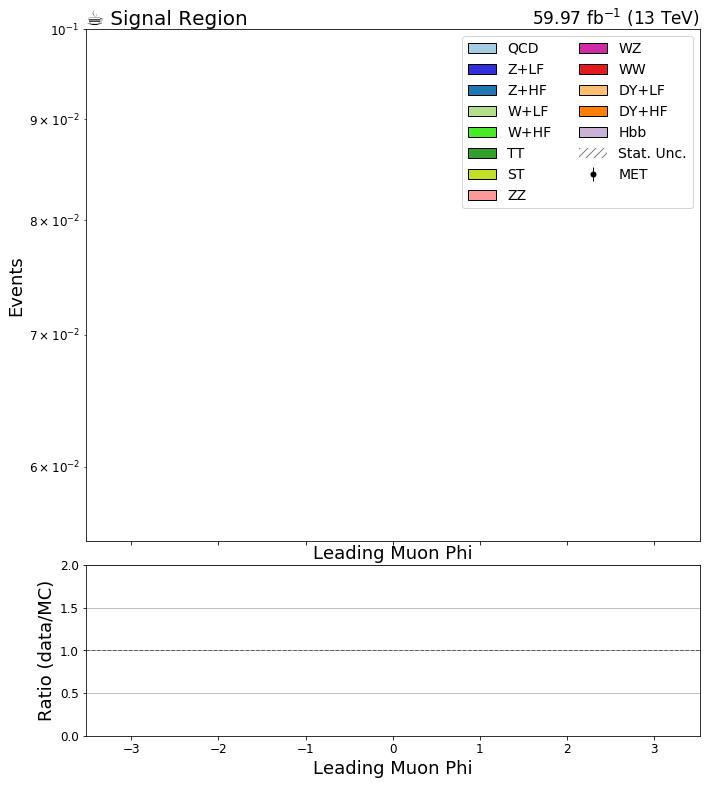

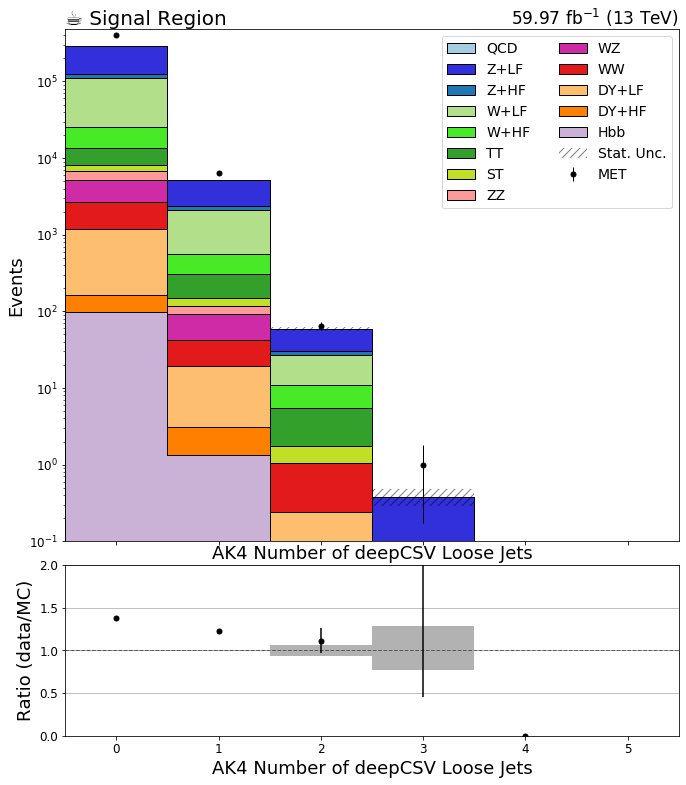

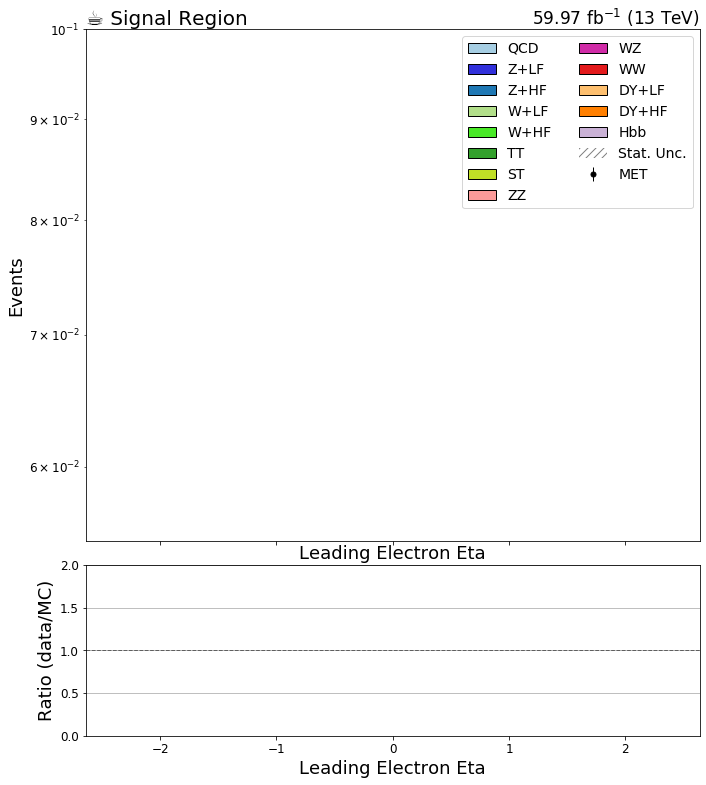

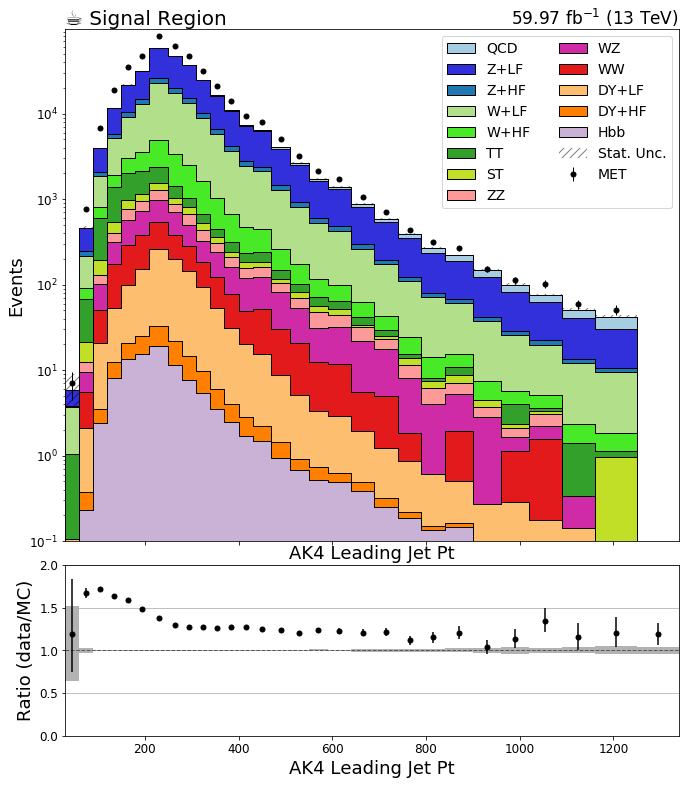

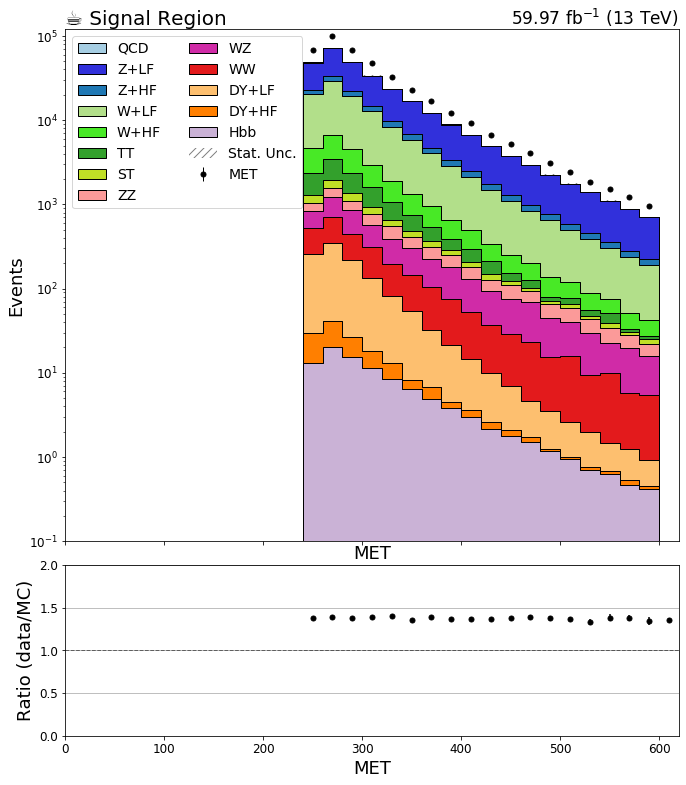

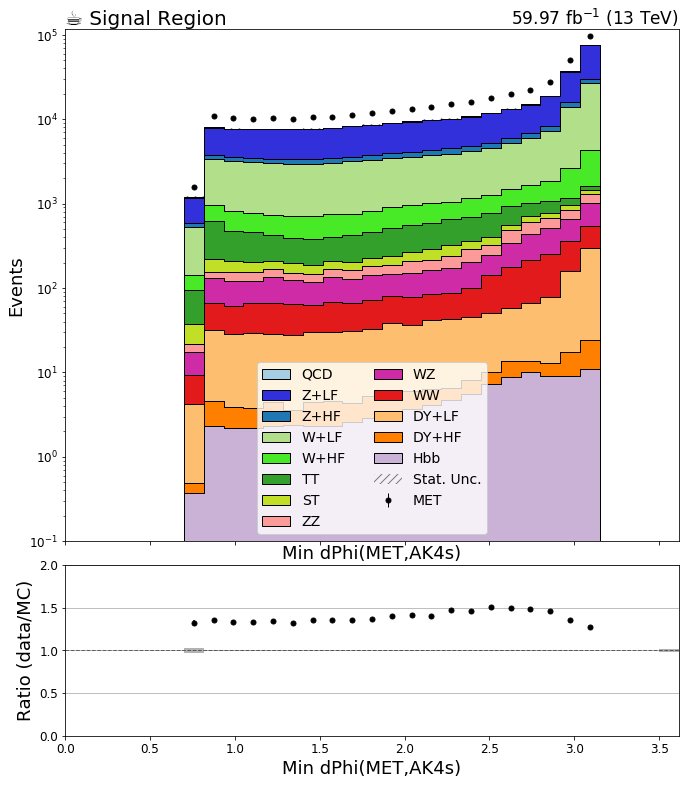

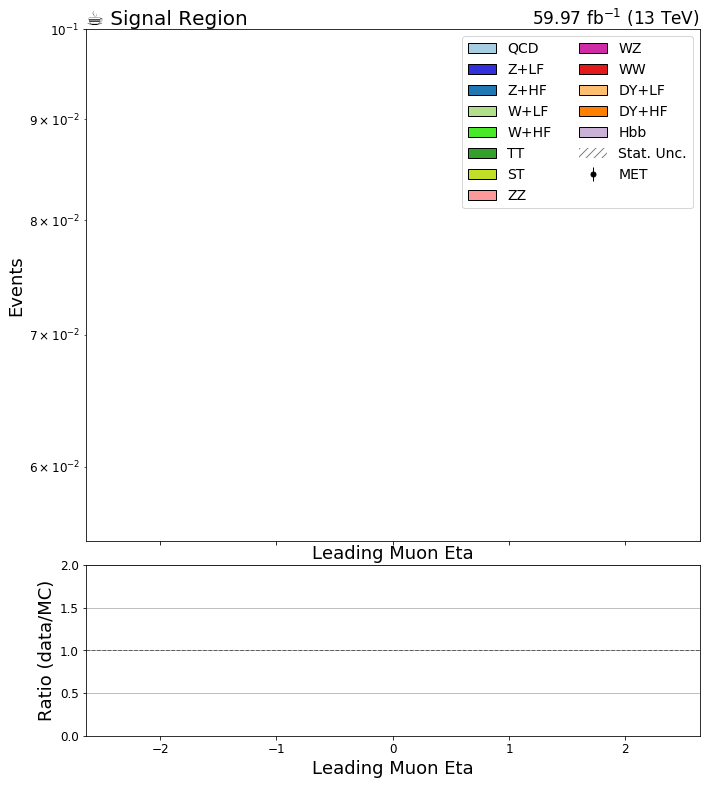

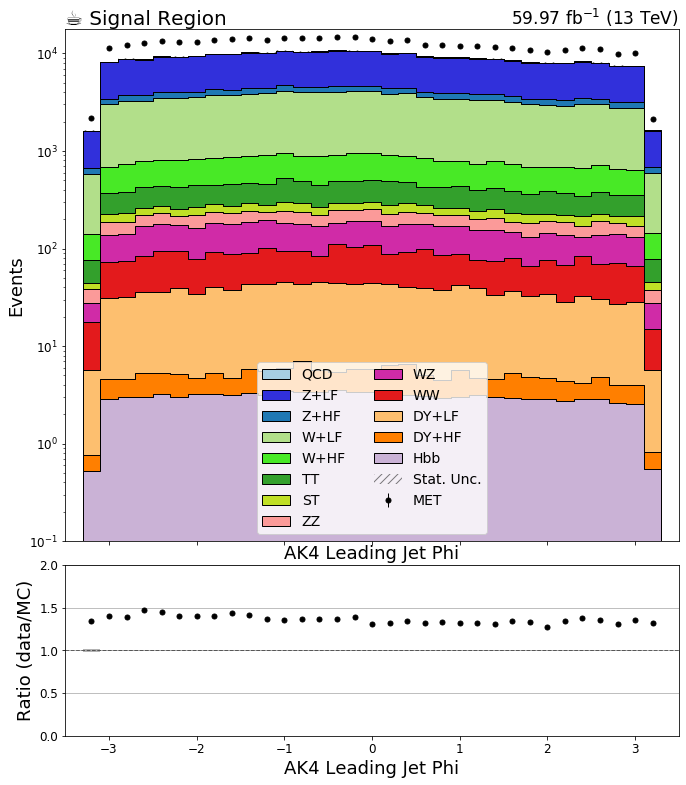

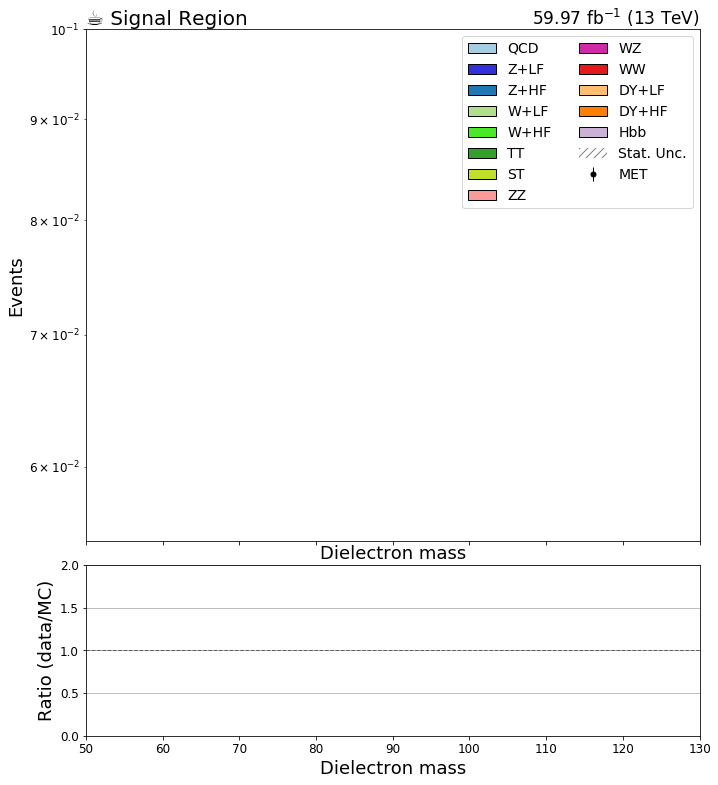

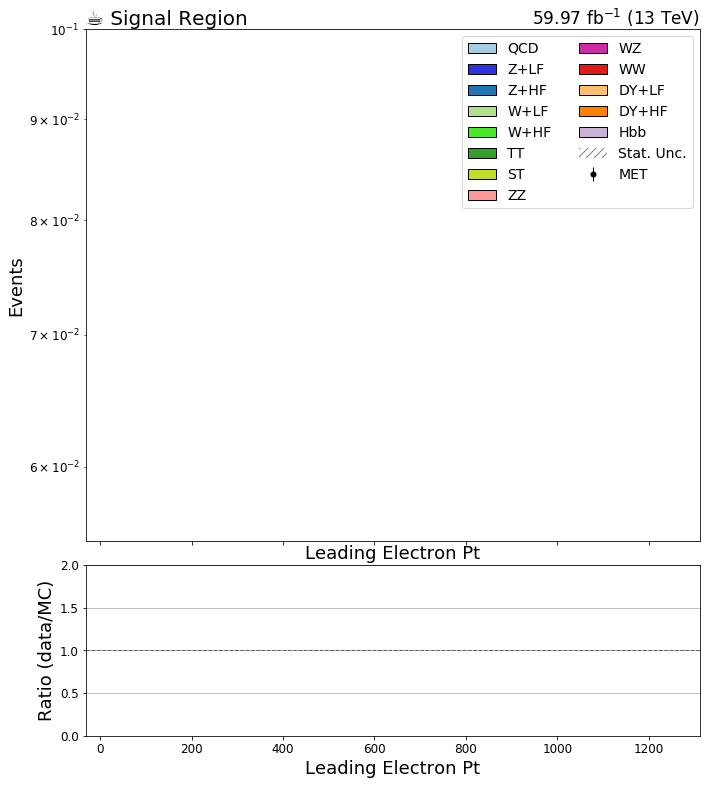

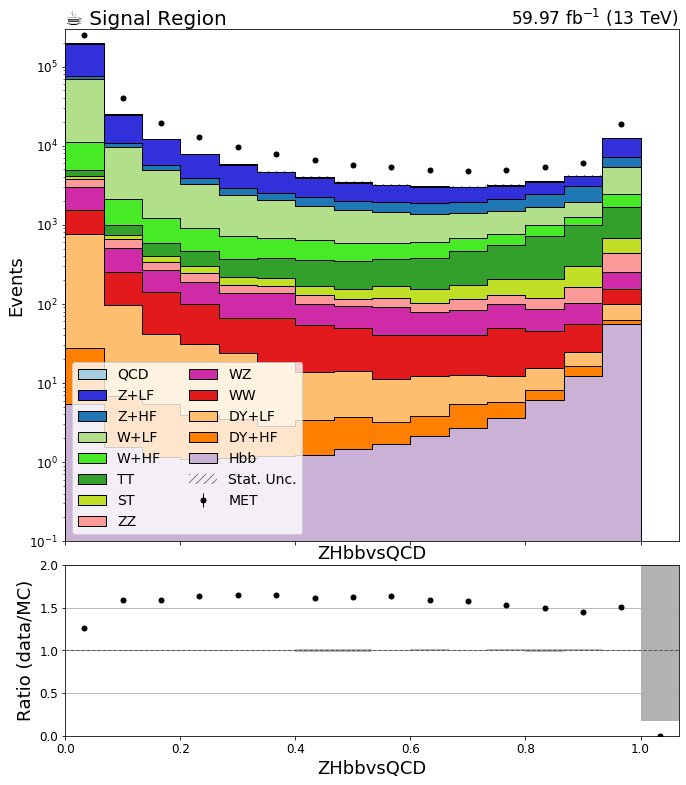

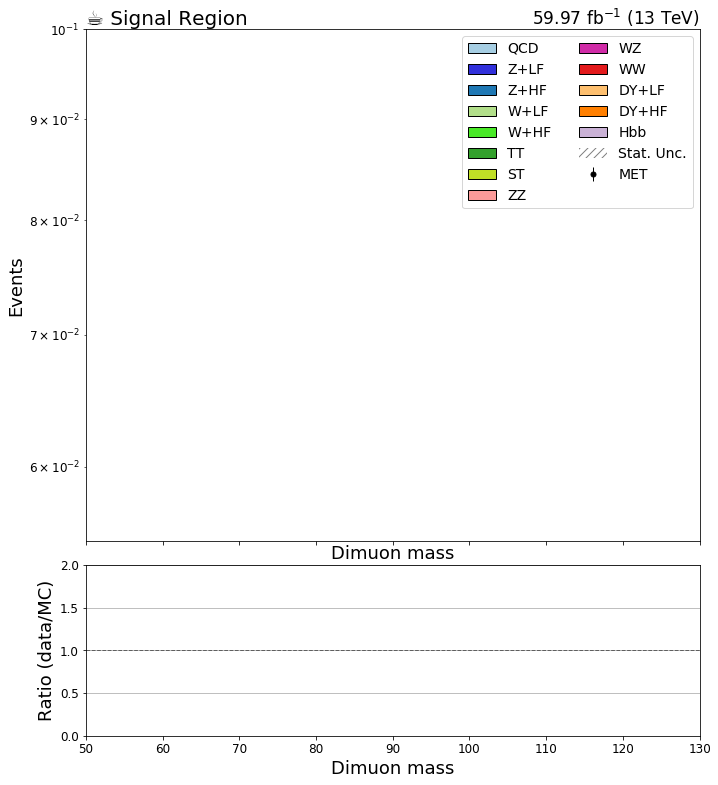

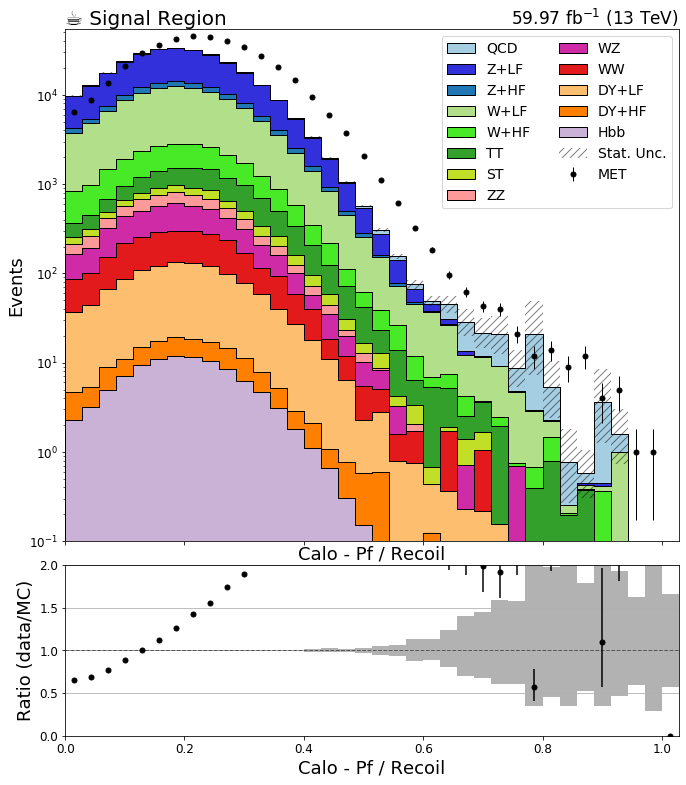

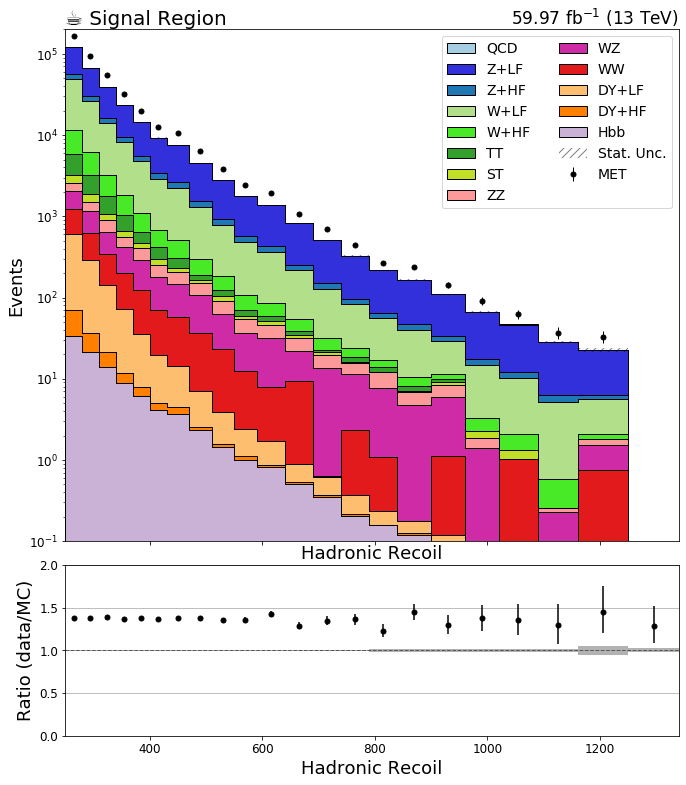

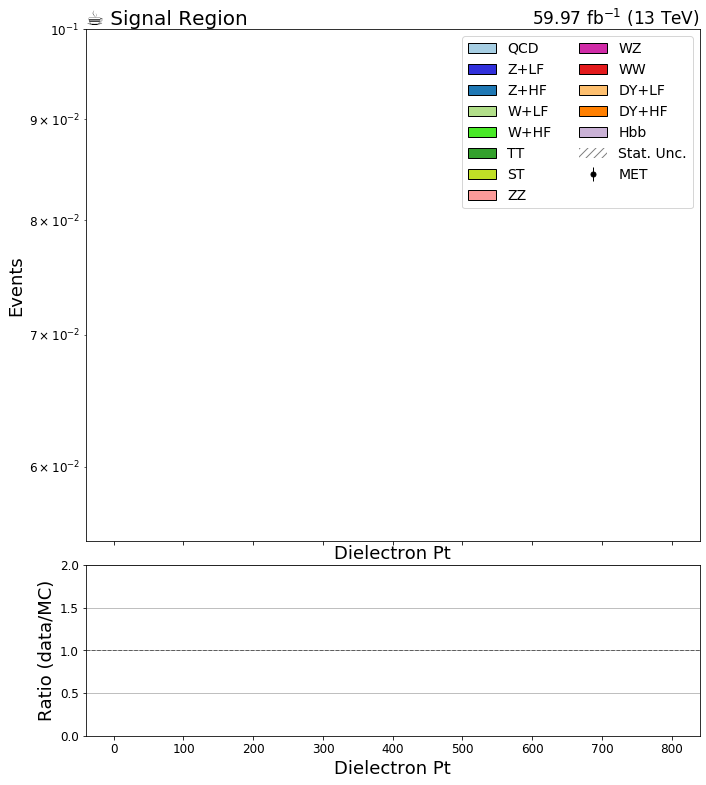

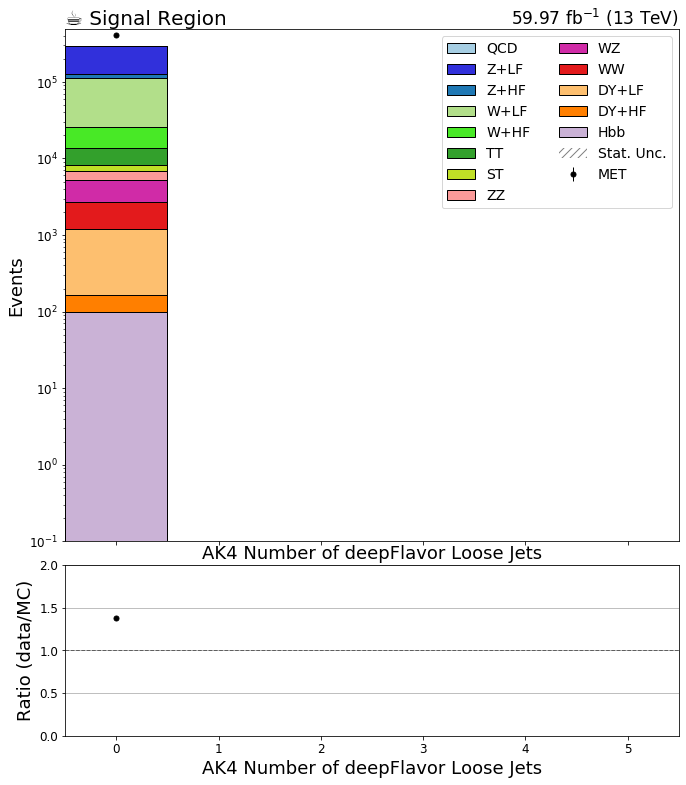

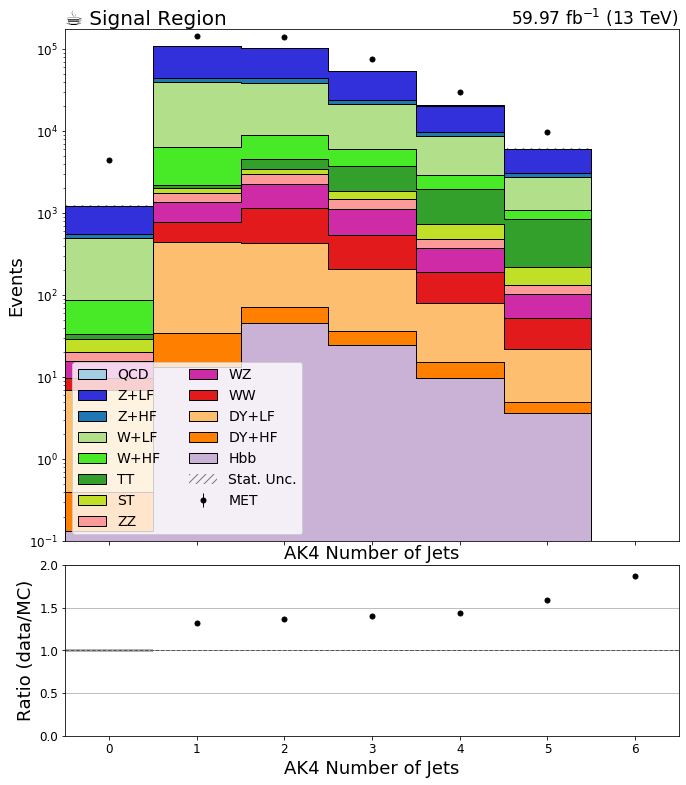

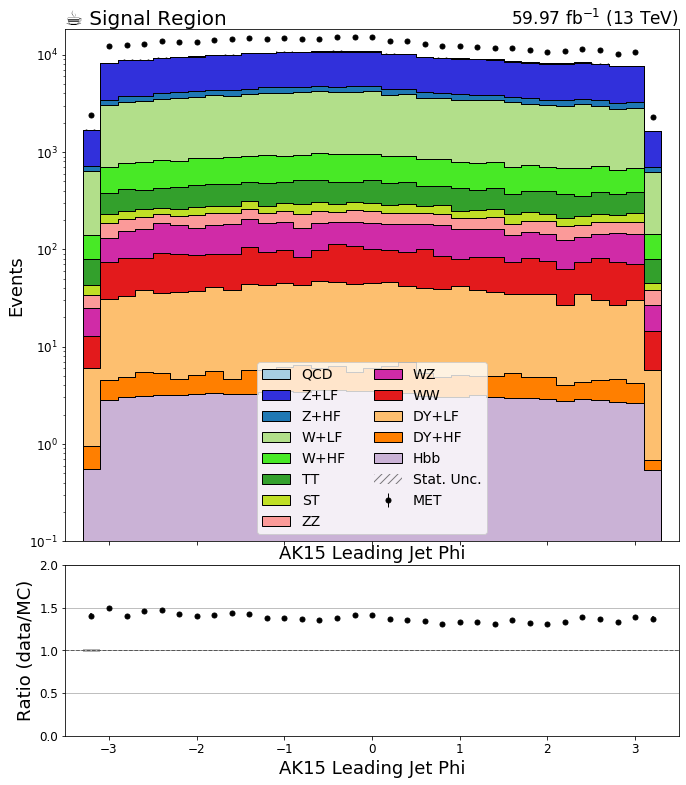

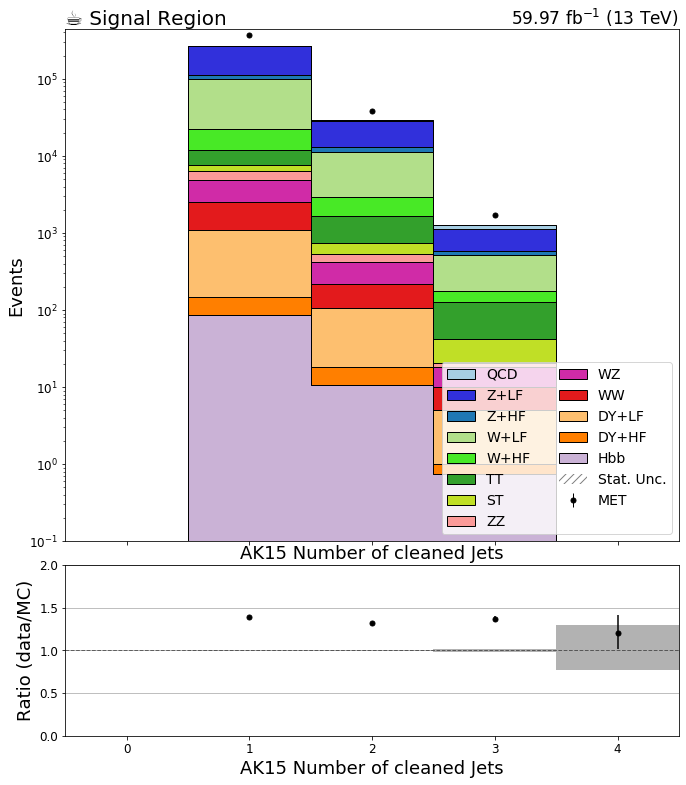

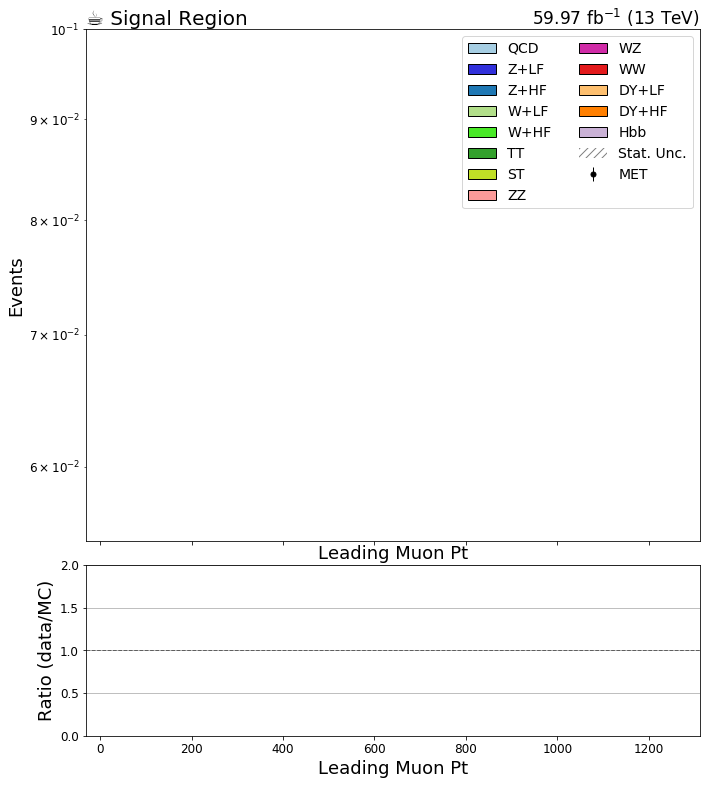

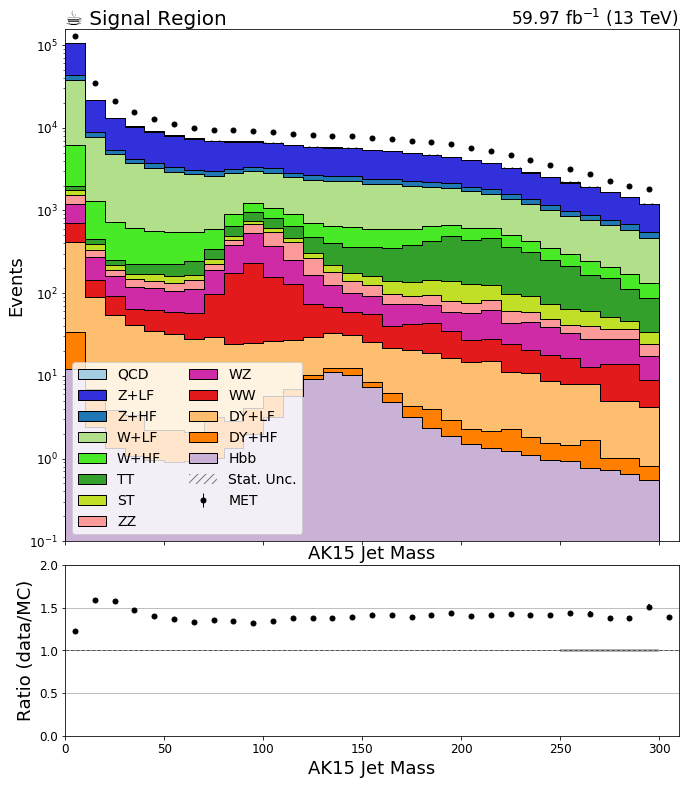

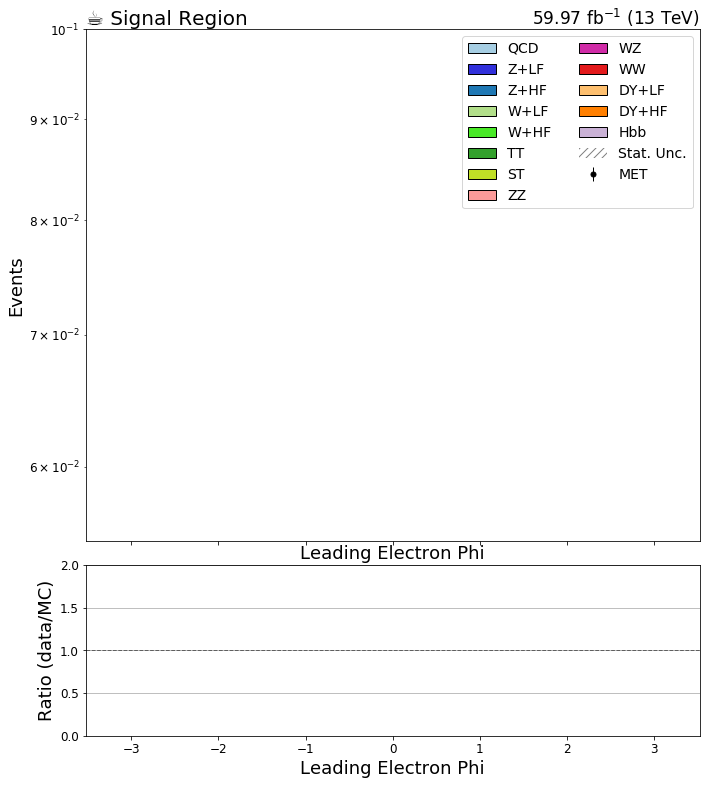

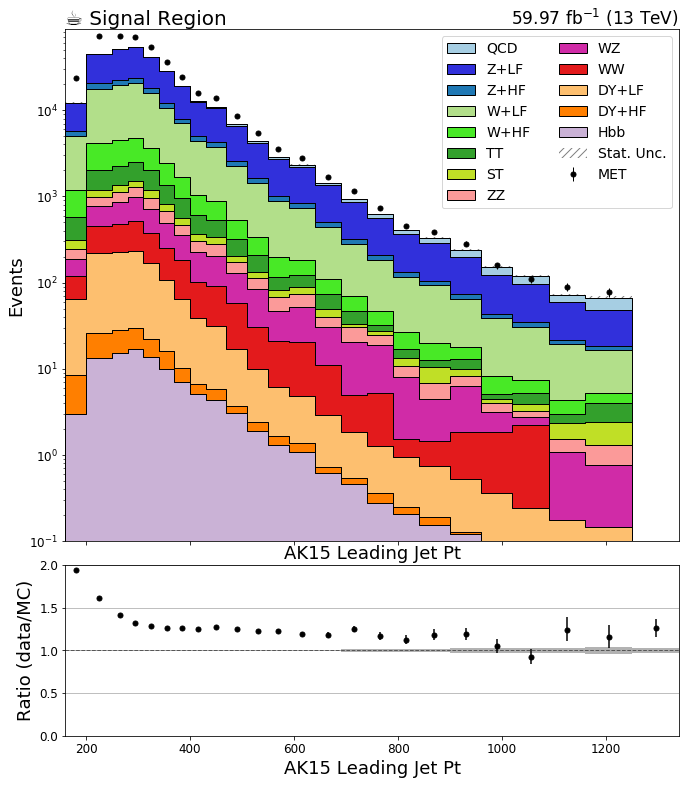

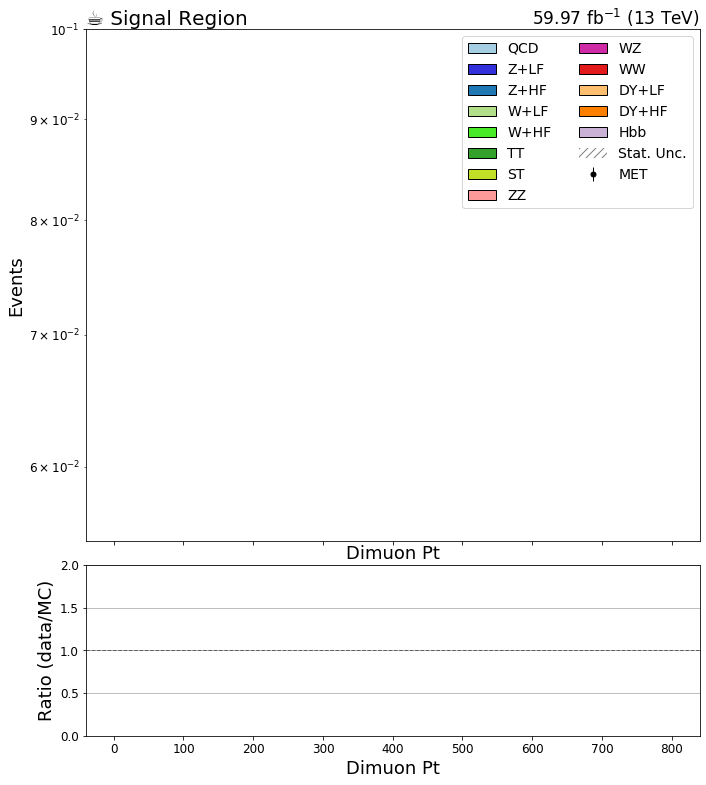

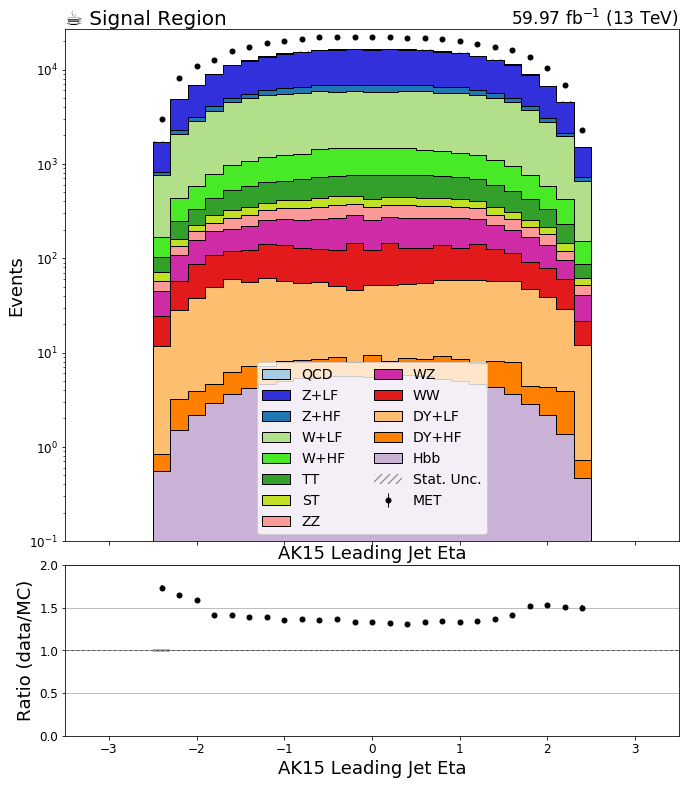

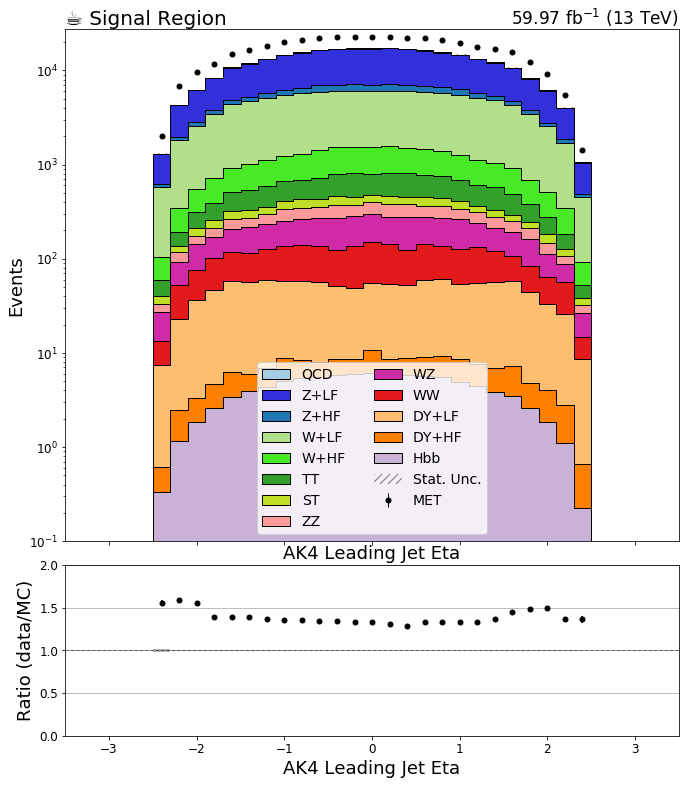

In [6]:
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
from cycler import cycler

region = 'sr'
sys = 'nominal'
data={}
data['sr'] = 'MET'
data['wmcr'] = 'MET'
data['tmcr'] = 'MET'
data['wecr'] = 'SingleElectron'
data['tecr'] = 'SingleElectron'
data['zmcr'] = 'MET'
data['zecr'] = 'SingleElectron'
data['gcr'] = 'SinglePhoton'

if not os.path.exists('../plots'):
    os.makedirs('../plots')
R = {}
R['sr'] = 'Signal Region'
R['wmcr'] = 'Single Muon W CR'
R['tmcr'] = 'Single Muon Top CR'
R['wecr'] = 'Single Electron W CR'
R['tecr'] = 'Single Electron Top CR'
R['zecr'] = 'Double Electron Z CR'
R['zmcr'] = 'Double Muon Z CR'
R['gcr'] = 'Single Photno CR'

sys = 'nominal'

for key in bkg_hists.keys():
    if key=='sumw': continue
    for j in bkg_hists[key].identifiers('region'):
        if not (str(j) == region): continue
        if str(j) == 'wmcr' or str(j) == 'tmcr' or str(j) == 'zmcr':
            if key == 'e1pt' or key == 'e1eta' or key == 'e1phi': continue
        if str(j) == 'wecr' or str(j) == 'tecr' or str(j) == 'zecr':
            if key == 'mu1pt' or key == 'mu1eta' or key == 'mu1phi': continue
            
        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
        #colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
        colors = ['#a6cee3', '#3130db', '#1f78b4', '#b2df8a', '#48e926', '#33a02c', '#c0df26',
                  '#fb9a99', '#d02ba7', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#c64bc4',
                  '#6a3d9a', '#a9ce26', '#ffff99', '#b15928', '#edcc43']


        fig, (ax, rax) = plt.subplots(2, 1, figsize=(11,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
        fig.subplots_adjust(hspace=.07)
        ax.set_prop_cycle(cycler(color=colors))
        

        plot.plot1d(data_hists[key].integrate('systematic',sys).integrate('region',j).sum('gentype')[data[str(j).split('_')[0]]],            
                overlay="process",
                ax=ax,
                clear=False,
                error_opts=data_err_opts
                   )

        plot.plot1d(bkg_hists[key].integrate('systematic',sys).integrate('region',j).sum('gentype'),
                overlay="process",
                ax=ax,
                clear=False,
                stack=True,
                fill_opts=fill_opts,
                error_opts=error_opts
                   )
        
        plot.plotratio(data_hists[key].integrate('systematic',sys).integrate('region',j).sum('gentype').integrate('process',data[str(j).split('_')[0]]), 
                   bkg_hists[key].integrate('systematic',sys).integrate('region',j).sum('gentype').sum('process'),
                   ax=rax,
                   overflow='over',
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num'
                   )
        
        rax.set_ylabel('Ratio (data/MC)')
        rax.set_ylim(0.0,2.0)
        rax.grid(axis='y')
        
        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        if(key=='dielemass' or key=='dimumass'): ax.set_xlim(50, 130)
        ax.set_ylim(.1, None)
        leg = ax.legend(ncol=2, loc='best')
        
        coffee = plt.text(0., 1., u"☕ "+R[str(j).split('_')[0]], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        lumi = plt.text(1., 1., r"59.97 fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
        plot_path = os.path.abspath('../plots') 
        plot_name = 'stack_'+key+'_'+R[str(j).split('_')[0]]+'.png'
        #fig.savefig(os.path.join(plot_path, plot_name))